<font color = green >


# Clustering part 2: Hierarchical clusterins and DBSCAN

</font>


In [26]:
import numpy as np 
import matplotlib.pyplot as plt 

In [27]:
%matplotlib notebook

<font color = green >

## Recall kmeans 

</font>

Note: Kmeans cannot capture complex clusters 

<font color = green >

### Data 

</font>


In [ ]:
def get_smile_points(pos=True, n = 100):
    np.random.seed(0) 
    x_noise = np.random.uniform(-0.1,0.1,int(n*1.2))
    y_noise = np.random.uniform(-0.1,0.1,int(n*1.2))
    x= np.linspace (-3,3,n)
    x_add= np.linspace (-3,-2.9,int(n/10))

    x= np.r_[x,x_add, -x_add]
    y_circle = np.sqrt(9-x**2)+ y_noise

    X= np.r_[x+x_noise, x-x_noise]
    Y = np.r_[y_circle, -y_circle]

    x= np.linspace (-2,2,int(n/2))
    y_lips = -np.sqrt(16-x**2) +4.5 + 2*y_noise[:int(n/2)]
    X_smile= x
    Y_pos= -np.sqrt(16-x**2) +2.5 + 2*y_noise[:int(n/2)] 
    Y_neg= np.sqrt(16-x**2) - 4.5 + 2*y_noise[:int(n/2)]

    # X= np.r_[X,X_smile]
    # Y = np.r_[Y,Y_neg]

    x= np.linspace (-.3,.3,int(n/16))
    y_eye = np.sqrt(.1-x**2) + y_noise[:int(n/16)]

    X= np.r_[X,x-1,x-1, x+1, x+1 ]
    Y = np.r_[Y,-y_eye+1, y_eye+1, -y_eye+1, y_eye+1]

    X= np.r_[X,X_smile]
    Y_1 = np.r_[Y,Y_pos]
    Y_2 = np.r_[Y,Y_neg]
    if pos:
        return np.array(list((zip(X,Y_1))))
    else: 
        return np.array(list((zip(X,Y_2))))

plt.figure(figsize=(6,6))
points= get_smile_points()
plt.plot (points[:,0], points[:,1],'.',c= 'grey')



In [ ]:
# deliberately created cell to avoid skipping next  cell execution

In [28]:
from sklearn.cluster import KMeans

In [ ]:
points = get_smile_points(pos=False)

In [ ]:
clf = KMeans(n_clusters=4) 
clf.fit(points)
predicted= clf.predict(points)

In [ ]:
plt.figure(figsize=(6,6))
colors=  np.array(['green','grey', 'orange', 'brown'])

# draw samples 
plt.scatter(points[:,0], points[:,1], c= colors[predicted], marker= '.')

# draw centroids 
for i, c in enumerate (clf.cluster_centers_):    
    plt.plot(c[0], c[1], marker = 'x', color= colors[i], markersize=14) 
    
plt.title ('sklearn kmeans')


In [ ]:
# deliberately created cell to avoid skipping next  cell execution

<font color = green >

## Hierarchical (agglomerative) clustering

</font>

Algorithm: <br>
$\quad\quad$ 1) Define number $K$ of clusters <br>
$\quad\quad$ 2) Each data point is put into its own cluster of one item <br>
$\quad\quad$ 3) Merge the most similar two clusters into a new cluster<br>
$\quad\quad$ 4) Repeat step 2 till number of remaining clusters succeeds $K$

<img src = "aglomerative_clustering.png" height=1000 width= 1000 align="left">



<font color = green >

### Linkage criteria 

</font>


There are following possible linkage criteria to determine the most similar clusters for agglomerative clustering algorithm:<br>
$\quad\quad$    1) ward - merges two clusters that give the smallest increase in total variance within all clusters<br>
$\quad\quad$    2) average - merges two clusters that have the smallest average distance between points<br>
$\quad\quad$    3) complete (maximum linkage) - merges the two clusters that have the smallest maximum distance between their points<br>
$\quad\quad$    4) single (minimum linkage) - merges the two clusters that have the smallest minimum distance between their points



<font color = green >

### Implemenation of single linkage 

</font>



<font color = green >

#### Cache all distances 

</font>

Caching the values of distances between each pair of points should speed up the process since merging clusters at every step of agglomerative clustering computes min distance between all pairs of points from both clusters 


In [ ]:
def calc_all_distances(points):
    all_distances = {}
    for i in range(len(points)):
        for j in range(i + 1):
            key_distance = '{}_{}'.format(i, j)
            reverse_key_distance = '{}_{}'.format(j, i)
            all_distances[key_distance] = all_distances[reverse_key_distance] = np.linalg.norm(points[i]-points[j])
    return all_distances

# test_points = np.array([[0,0], [1,1], [2,2], [7,7], [8,8], [9,9]])
# print(test_points)
# calc_all_distances(test_points)



In [ ]:
# implement single distance  between 2 clusters 
def calc_min_distance_of_two_clusters(cluster_a, cluster_b, all_distances):
    '''
    :param cluster_a -  list e.g. [1,4,56]
    :param cluster_b -  list e.g. [2,34,78]
    :all_distances -  dict e.g.{'0_0': 0.0, '1_0': 0.5630650985836898, '0_1': 0.5630650985836898, '1_1': 0.0, '2_0': 0.9000430792627307, '0_2': 0.9000430792627307,
    :return - min distance between all pairs fo two clusters 
    '''
    return min([all_distances['{}_{}'.format(keyword_index_a,keyword_index_b)] for keyword_index_a in cluster_a for keyword_index_b in cluster_b])

# choose the closest clusters 
def compute_next_merge(clusters, all_distances):
    '''
    calculates candidates ( the closest by similarity clusters)
    :param resulted_clusters: dictionary like {3: [15,3,56,1]}
    :return: calculated score 
    '''
    labels= list(clusters.keys())
    # init score
    min_distance = calc_min_distance_of_two_clusters(clusters[labels[0]],clusters[labels[1]],all_distances )
    # init the canidates
    clusters_to_merge = [labels[0], labels[1]] 
    for i in range (len(labels)-1):
        for j in range(i+1,len(labels)):
            curr_min_distance= calc_min_distance_of_two_clusters(clusters[labels[i]],clusters[labels[j]], all_distances)
            if curr_min_distance < min_distance: 
                min_distance = curr_min_distance
                clusters_to_merge = [labels[i],labels[j]]
    return min_distance, clusters_to_merge

# merge two closest clusters 
def merge_clusters(current_clusters,clusters_to_merge):
    '''
    :param current_clusters: dict of pairs: label and cluster (list of indices of keywords) e.g. {1: [23,5,5]}
    :param clusters_to_merge: list of 2 labels of closest clusters - candidates to merge e.g. [34,57]
    :return:
    '''
    # replace the first component by merged cluster
    current_clusters[clusters_to_merge[0]] += current_clusters[clusters_to_merge[1]]
    # remove the second component from total list  
    del current_clusters[clusters_to_merge[1]]
    return current_clusters


# run clustering process 
def run_agglomerative_clustering(points, n_clusters=1):
    resulted_clusters={i: [i] for i in range(len(points))}    
    while len(resulted_clusters)>n_clusters:
        # determinethe closest clusters
        min_distance, clusters_to_merge=  compute_next_merge(resulted_clusters, all_distances)        
        
        # print progress
        if (len(resulted_clusters)) % 10 == 0:
            print ('len(clusters)= {:,} distance = {}'.format(len(resulted_clusters), min_distance))
        
        # merge 2 closest clusters         
        resulted_clusters= merge_clusters(resulted_clusters, clusters_to_merge)
    return resulted_clusters





<font color = green >

#### Shuffle the points 

</font>


In [ ]:
points= get_smile_points()
print (points[:5])
np.random.shuffle(points) 
print ('\n shuffled:\n', points[:5])

<font color = green >

#### Cache all distances for target points 

</font>


In [ ]:
# cache all distances  
all_distances=  calc_all_distances(points)
print ('len (points)= {:,}'.format(len (points)))
print ('len (all_distances)= {:,}'.format(len (all_distances)))

<font color = green >

#### Launch agglomerative clustering 

</font>


In [ ]:
n_clusters= 4
results = run_agglomerative_clustering(points, n_clusters=n_clusters)
print ('\nClustering complete.')

<font color = green >

#### Visualize results 

</font>


In [ ]:
# print structure of results 
for k, value in results.items():
    print ('index = {} (len = {:,}) : {}'.format(k, len(value), value[:10] ))
    
# enumerate the inices of clusters     
enumerated= {i: value[1] for i, value in enumerate(results.items())}
# create list of cluster indices 
predicted= [k for i in range(len(points))     for k, v in enumerated.items()  if i in v ]

# predicted= compute_current_clusters_indices(results, n_clusters)
print ('\nPredicted cluster indices for points:\n',predicted)

In [ ]:
plt.figure(figsize=(6,6))
colors=  np.array(['green','grey', 'orange', 'brown', 'blue', 'yellow'])
plt.scatter(points[:,0], points[:,1], c= colors[predicted], marker= '.')    
plt.title ('manual agglomerative')

<font color = green >

### Visualize process of merging 

</font>


In [ ]:
from matplotlib import animation
# from tqdm import tqdm # use for displaying progress 
from time import sleep 
from tqdm import trange # use for displaying progress 


<font color = green >

#### Convert format of cluster objects to list of clusters indices 

</font>


In [ ]:
def compute_current_clusters_indices(curr_clusters, clusters_to_merge):
    ind_a, ind_b = clusters_to_merge
    predicted = []
    for i in range(len(points)): # index of point 
        for k, v in curr_clusters.items(): # k - index of cluster , v - list of indices of points 
            if i in v: # point pertains to this cluster 
                if k == ind_a:
                    predicted.append(2) # is going to be merged from cluster 1
                elif k == ind_b:
                    predicted.append(3) # is going to be merged from cluster 2
                elif len(v)>1: 
                    predicted.append(0) # merged at least once 
                else:
                    predicted.append(1) # never merged at least once 

    return predicted


<font color = green >

#### Animate the clustering steps

</font>


In [ ]:
def update(curr): # note: does not notify about errors just does not work. ain't that b... ((
    ax.clear()
    colors=  np.array(['green','grey', 'orange', 'brown', 'blue', 'yellow'])
    sizes = np.array([30,30,60, 60, 300, 30])

    global points
    x1, x2 = np.array(list((zip(*points))))

    global resulted_clusters
    global all_distances
    global n_clusters

    if len(resulted_clusters)<= n_clusters:
        a.event_source.stop()
    
    # perfrom step of agglomerative clustering but plot the clusters to merge before merging      
    min_distance, clusters_to_merge=  compute_next_merge(resulted_clusters, all_distances)        
    curr_predicted= compute_current_clusters_indices(resulted_clusters, clusters_to_merge)#  first_cluster)
    plt.scatter(x1, x2, c= colors[curr_predicted], marker= '.', s= sizes[curr_predicted])       
    
    resulted_clusters= merge_clusters(resulted_clusters, clusters_to_merge)
    

    # ax.plot(np.random.rand(10)) # use to test annimation is working
    plt.title('len(clusters)= {:,} distance = {}'.format(len(resulted_clusters)+1, min_distance)) 

# init clusters - one per point  
resulted_clusters={i: [i] for i in range(len(points))}    

print ('Running some iterations w/o plotting...')
sleep(.5) # .5 seconds  - to avoid progress bar splitted to two 
for i in trange(260): # Running some iterations w/o plotting
    min_distance, clusters_to_merge=  compute_next_merge(resulted_clusters, all_distances)        
    resulted_clusters= merge_clusters(resulted_clusters, clusters_to_merge)

fig = plt.figure(figsize=(6,6))
ax = plt.gca()
a = animation.FuncAnimation(fig, update, interval=1000) # Note: you need to assign the result in order to be able to stop the animation 


<font color = green >

## Sklearn 

</font>


In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
points = get_smile_points(pos=False)
clf = AgglomerativeClustering(n_clusters=4, linkage= 'ward')  # single linkage was not available in sklearn 
# available linkage : {“ward”, “complete”, “average”, “single” ! WRONG ! }, optional (default=”ward”)
predicted = clf.fit_predict(points)


In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], c= colors[predicted], marker= '.') 
plt.title ('sklearn kmeans')


In [ ]:
# single linkage is now available in sklearn 
points = get_smile_points()
clf = AgglomerativeClustering(n_clusters=4, linkage= 'single') 
predicted = clf.fit_predict(points)

plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], c= colors[predicted], marker= '.') 
plt.title ('sklearn kmeans')


<font color = green >

## Scipy

</font>


In [ ]:
from scipy.cluster.hierarchy import complete, average, linkage, single, dendrogram
import itertools

<font color = green >

### Condensed matrix

</font>


In [ ]:
def calc_condensed_matrix(points):
    '''
    Computes the condensed distance matrix
    e.g. for 3 elements:  [dist(0,1), dist(0,2),dist(1,2)]
    e.g. for 4 elements: [dist(0,1), dist(0,2), dist(0,3), dist(1,2), dist(1,3), dist(2,3)]
    '''

    m= len(points)
    # compute number of combinations      
    combinations = list(itertools.combinations(range(m), 2))
    len_of_condensed_matrix= len(combinations)
    # init matrix of necessary size      
    condensed_matrix= np.zeros(len_of_condensed_matrix)    
    
    for i in trange(len_of_condensed_matrix):
        pair_indices= combinations[i]
        condensed_matrix[i] =  np.linalg.norm(points[pair_indices[0]]-points[pair_indices[1]])

    return condensed_matrix

# calc_condensed_matrix(test_points)

In [ ]:
points = get_smile_points()
print (len(points))

In [ ]:
# compute condensed matrix 
condensed_matrix = calc_condensed_matrix(points)


<font color = green >

### Linkage matrix

</font>


In [ ]:
linkage_matrix = single(condensed_matrix)
# each row is step of merging: 
# [0] and [1] are indices of clusters to merge, 
# [2] - distance at that merging 
#  number of members in resulted cluster after merging  

print ('len(linkage_matrix)= ', len(linkage_matrix))
linkage_matrix[50:]

<font color = green >

### Merge two clusters managed by scipy 

</font>

This requires correction by creating new labels (cluster indices) as they are in linkage matrix provided by scipy 

In [ ]:
def merge_clusters_scipy(current_clusters,clusters_to_merge, new_label, expected_total):
    '''
    :param current_clusters- dict, keys are indices of clusters, values are lists of indices of points e.g. {1: [23,5,5]...}
    :param clusters_to_merge: list of 2 labels of closest clusters - candidates to merge e.g. [34,57]
    :param new_label: int - the label generated by scipy.cluster.hierarchy
    :param expected_total: optional  - to check the anount of new cluster after merge due to provided by scipy.cluster.hierarchy
    :return:
    '''
    ind_a, ind_b = clusters_to_merge
    current_clusters[new_label] = current_clusters[ind_a] + current_clusters[ind_b]
    assert(len(current_clusters[new_label]) == expected_total)

    del current_clusters[ind_a]
    del current_clusters[ind_b]

    return current_clusters


<font color = green >

### Execute clustering managed by linkage matrix 

</font>

In [ ]:
# init clusters - one cluster for every keyword
resulted_clusters= {i: [i] for i in range(len(points))} 

for i in range (len(linkage_matrix) - n_clusters + 1):    
    
    # get indices of clusters to merge 
    clusters_to_merge = (linkage_matrix[i,0],linkage_matrix[i,1])        
    
    # consider expected numbers of new cluster after merge for check 
    excpected_total =  linkage_matrix[i,3]    

    # replicate the label generated by scipy.cluster.hierarchy
    new_label = i + len(points) 
    
    # execute merging    
    resulted_clusters= merge_clusters_scipy(resulted_clusters, clusters_to_merge, new_label, excpected_total)


# outliers= [label for label in resulted_clusters if len(resulted_clusters[label][0])==1]
# print ('\n= Results =')
# print ('Clusters number: {:,}'.format(len(resulted_clusters)-len(outliers)))
# print ('Outliers number: {:,}'.format(len(outliers)))


<font color = green >

### Review resulted clusters

</font>

In [ ]:
for k,v in resulted_clusters.items():
    print ('{}:{}'.format (k, v[:10]))


<font color = green >

### Visualize results 

</font>

In [ ]:
# enumerate the inices of clusters     
enumerated= {i: value[1] for i, value in enumerate(resulted_clusters.items())}
# create list of cluster indices 
predicted= [k for i in range(len(points))     for k, v in enumerated.items()  if i in v ]
print (predicted)

In [ ]:
plt.figure(figsize=(6,6))
colors=  np.array(['green','grey', 'orange', 'brown', 'blue', 'yellow'])
plt.scatter(points[:,0], points[:,1], c= colors[predicted], marker= '.')    
plt.title ('scipy agglomerative')

<font color = green >

## Dendrogram

</font>

In [ ]:
test_points = np.array([[0,0], [1,1], [3,3], [7,7], [7,8], [20,20],[22,22] ])
condensed_matrix_test = calc_condensed_matrix(test_points)
linkage_matrix_test = single(condensed_matrix_test)
plt.figure()
dendrogram(linkage_matrix_test);

In [ ]:
# plt.figure(figsize=(8,10))
# dendrogram(linkage_matrix,no_labels=True, )

<font color = green >

## Sample of clustering keywords 

</font>

In [ ]:
import pickle
import time
import itertools
from scipy.cluster.hierarchy import complete, dendrogram, average, linkage
from sklearn.feature_extraction.text import CountVectorizer
import re
import math
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from tqdm import trange 


In [ ]:
def convert_siliratity_to_distance(phrase_similarity):
    return 20 if phrase_similarity==0 else abs(math.log(phrase_similarity,0.8))  # abs to avoid -0.0 but probably it's ok

def calc_phrase_similarity(current_phrase, target_phrase):
    '''
    current_phrase - str - one of all phrases in the list
    target phrase is stored in self.target_words
    '''
    if len (current_phrase)== 0 or len(target_phrase)== 0:
        return 0

    # target_phrase_words = word_tokenize(target_phrase)
    target_phrase_words = word_tokenize(target_phrase)
    target_phrase_words= remove_stop_words(target_phrase_words)
    # current_phrase_words = word_tokenize(current_phrase)
    current_phrase_words = word_tokenize(current_phrase)
    current_phrase_words = remove_stop_words(current_phrase_words)

    tw_all_similarities= [target_word_similarity_score(current_phrase_words, tw) for tw in target_phrase_words]
    if len(tw_all_similarities)>0:
        tw_similarity= np.mean(tw_all_similarities)
    else:
        tw_similarity =  0

    cw_all_similarities= [target_word_similarity_score(target_phrase_words, cw) for cw in current_phrase_words]
    if len(cw_all_similarities)>0:
        cw_similarity= np.mean(cw_all_similarities)
    else:
        cw_similarity = 0

    return np.mean([tw_similarity, cw_similarity])


def target_word_similarity_score(current_words, target_word):
    '''
    Calculates similarity between all current words (all synsets) and ONE target word (all synsets)
    in case word has no synsets the Levinshtein distance is calculated and score calculated as 0.8^Ld (1 diff - 0.8, 2 - 0.64, 3- 0.51, ...)
    :param current_words: list of words of current phrase
    :param target_word: str
    :return: float
    '''
    if len(current_words)==0:
        return 0
    all_current_words_similarities= []
    for current_word in current_words:
        all_current_words_similarities.append(calc_memoized_words_similarity(current_word, target_word))
    if len(all_current_words_similarities)==0:
        return 0
    return max(all_current_words_similarities)

def calc_memoized_words_similarity(word_a, word_b):
    '''wrapper on calc_words_similarity'''
    key_memo = '{}_{}'.format(word_a, word_b)
    if key_memo in memoized_words_similarity:
        return memoized_words_similarity[key_memo]
    key_memo_reversed = '{}_{}'.format(word_b,word_a)
    if key_memo_reversed in memoized_words_similarity:
        return memoized_words_similarity[key_memo_reversed]
    memoized_words_similarity[key_memo] = calc_words_similarity(word_a,word_b)
    return memoized_words_similarity[key_memo]

def calc_words_similarity(word_a,word_b):
    ''' Calculates wup similarity if synsets available else score based on edit distance
        in case of synsets available returns max of all values
    '''
    word_a_synsets = get_memoized_synsets(word_a)
    word_b_synsets = get_memoized_synsets(word_b)
    if len (word_a_synsets)==0 or len (word_b_synsets)==0:
        return calc_edit_score(word_a,word_b)
    else:
        similarities_all_synsets= []
        for word_a_synset in word_a_synsets:
            for word_b_synset in word_b_synsets:
                if word_a_synset.pos() == word_b_synset.pos():  # this speeds up the calculation
                    synsets_similarity =  calc_memoized_similarity(word_a_synset, word_b_synset)
                    if synsets_similarity: # some time return None
                        similarities_all_synsets.append(synsets_similarity)
                    else:
                        similarities_all_synsets.append(0)
                else:
                    similarities_all_synsets.append(0)
        return max(similarities_all_synsets)

def get_memoized_synsets(word):
    if word not in memoized_synsets:
        memoized_synsets[word]= wn.synsets(word)
    return memoized_synsets[word]


def calc_memoized_similarity (current_word_synset, target_word_synset):
    key_memo = '{}_{}'.format(current_word_synset.name(),target_word_synset.name())
    if key_memo in memoized_synsets_similarities:
        return memoized_synsets_similarities[key_memo]
    key_memo_reversed = '{}_{}'.format(target_word_synset.name(), current_word_synset.name())
    if key_memo_reversed in memoized_synsets_similarities:
        return memoized_synsets_similarities[key_memo_reversed]
    memoized_synsets_similarities[key_memo] = current_word_synset.wup_similarity(target_word_synset)
    return memoized_synsets_similarities[key_memo]

def calc_edit_score(w1, w2):
    '''calc the score being based on edit (Levinshtein) distance
        1 difference - 0.8, 2- 0.64, 3-.51 ...
    '''
    edit_dist = nltk.edit_distance(w1, w2)
    if edit_dist> len (w1) or edit_dist> len (w2): # no common letter
        return 0
    return 0.8 ** edit_dist


def remove_stop_words(words):
    words_to_remove = [w for w in words if w in stop_words]# or len(w)<3]  # # remove short words # Note: Decided to keep all tokens to avoid empty results
    return [w for w in words if w not in words_to_remove]

def calc_condensed_matrix_keywords(keywords_list):
    '''
    Computes the condensed distance matrix
    e.g. for 3 elements:  [dist(0,1), dist(0,2),dist(1,2)]
    e.g. for 4 elements: [dist(0,1), dist(0,2), dist(0,3), dist(1,2), dist(1,3), dist(2,3)]
    '''
    fn = 'distance_matrix_pickle_{}'.format(len(keywords_list))
    
    if not os.path.exists(fn):
        len_keywords= len(keywords_list)
        len_of_condensed_matrix= len(list(itertools.combinations(range(len_keywords), 2)))
        condensed_matrix= np.zeros(len_of_condensed_matrix)
        all_combinations= list(itertools.combinations(range(len_keywords), 2))
        last_progress= 0
        for i in trange(len_of_condensed_matrix):
            current_progress = '{:.1%}'.format(i/len(all_combinations))
            if current_progress !=last_progress:
#                 print ('Progress = {:,} of {:,} ({:.1%})'.format(i, len(all_combinations), (i/len(all_combinations))))
                last_progress= current_progress
            pair_indeces= all_combinations[i]
            condensed_matrix[i] = convert_siliratity_to_distance(calc_phrase_similarity(keywords_list[pair_indeces[0]], keywords_list[pair_indeces[1]]))

        with open(fn, "wb") as f:  # write bytes mode
            pickle.dump(condensed_matrix, f, pickle.HIGHEST_PROTOCOL)

    else:
        print ('Condensed distance matrix is precomputed already')
        with open(fn, 'rb') as f:
            condensed_matrix = pickle.load(f)

    return condensed_matrix

def merge_clusters(current_clusters,clusters_to_merge, new_label, expected_total):
    '''
    :param current_clusters: dict of pairs: label and (cluster+main_phrase)  =  (list of indices of keywords) e.g. {1: [23,5,5]}
        main phrase is the first keyword at creating cluster - lets consider it as core of cluster since it gets merged first - thus the closest to all rest
    :param clusters_to_merge: list of 2 labels of closest clusters - candidates to merge e.g. [34,57]
    :param new_label: int  - the label generated by scipy.cluster.hierarchy
    :param expected_total: optional  - to check the anount of new cluster after merge due to provided by scipy.cluster.hierarchy
    :return:
    '''
    new_list =current_clusters[clusters_to_merge[0]][0]+ current_clusters[clusters_to_merge[1]][0]
    main_phrase = current_clusters[clusters_to_merge[0]][1]
    current_clusters[new_label] = (new_list, main_phrase)
    if len (current_clusters[new_label][0]) != expected_total:
        raise SystemExit('Error at merging clusters')

    del current_clusters[clusters_to_merge[0]]
    del current_clusters[clusters_to_merge[1]]

    return current_clusters


def get_frequent_words(keywords_list, top_number= 3):
    # print (keywords_list)
    vect = CountVectorizer().fit(keywords_list)
    features = vect.get_feature_names()
    all_words = ' '.join(keywords_list)
    # words_count_dict = ({w: all_words.count(w) for w in re.findall(r"[\w]+", all_words) if len(w) > 2})
    features_count_dict = {feature: all_words.count(feature) for feature in features if len(feature) > 2}
    if len(features_count_dict)<top_number:
        return sorted(features_count_dict , key=features_count_dict .get, reverse=True)
    return sorted(features_count_dict , key=features_count_dict .get, reverse=True)[:top_number]



<font color = green >

### Load data

</font>

In [ ]:
fn=  'keywords_set.xlsx'
df_keywords = pd.read_excel(fn, skiprows=11)  
all_keywords= df_keywords['Keyword'].values

keywords= list(np.random.choice(all_keywords,50))

print ('len(keywords)= {:,}\n'.format(len(keywords)))
print (keywords)

<font color = green >

### Compute condensed matrix 

</font>

In [ ]:
stop_words = set(stopwords.words('english'))
memoized_words_similarity= {}
memoized_synsets_similarities= {}
memoized_synsets = {}

# print ('\n= Calculating distance matrix =')

condensed_matrix= calc_condensed_matrix_keywords(keywords)


<font color = green >

### Run clustering

</font>

In [ ]:
similarity_threshold= 0.8
print ('similarity_threshold = {}%'.format(similarity_threshold*100))

distance_threshold = convert_siliratity_to_distance(similarity_threshold)
resulted_clusters={i: ([i], keywords[i]) for i in range(len(keywords))} # every cluster is label/int: ([]/list, main_keyword/str))
linkage_matrix = complete(condensed_matrix) # this represents the max distance measure  - consider the fareest in the cluster

continue_clustering= True
step_number = 0
while continue_clustering:
    clusters_to_merge = (linkage_matrix[step_number,0],linkage_matrix[step_number,1])
    excpected_total =  linkage_matrix[step_number,3]
    next_distance = linkage_matrix[step_number,2]
    new_label = step_number + len(keywords)

    if next_distance < distance_threshold :
        resulted_clusters= merge_clusters(resulted_clusters, clusters_to_merge, new_label, excpected_total)
        step_number +=1
        if step_number>=len(linkage_matrix):
            continue_clustering = False
    else:
        continue_clustering= False

    
        

<font color = green >

### Review results 

</font>

In [ ]:
outliers= [label for label in resulted_clusters if len(resulted_clusters[label][0])==1]
print ('Clusters number: {:,}'.format(len(resulted_clusters)-len(outliers)))
print ('Outliers number: {:,}'.format(len(outliers)))


# print members
for label in resulted_clusters:
    cluster_suggested_name= resulted_clusters[label][1]
    cluster_suggested_name = ' '.join(remove_stop_words(word_tokenize(cluster_suggested_name)))

    cluster_members= list(keywords[resulted_clusters[label][0]])
    if len(cluster_members)==1:
        print ('[keyword] {}'.format(cluster_suggested_name))
    else:
        print('[cluster] "name: {}" / {:,} keywords / tags: {}'.format(cluster_suggested_name, len(cluster_members), get_frequent_words(cluster_members)))
        print ('\t{}\n'.format(cluster_members))    

<font color = green >

## DBSCAN (density-based spatial clustering of applications with noise)

</font>
<br>
<br>
<img src = "dbscan.png"  align = 'left'>

$\quad$Point is core sample if there are **min_sample** of other data points 
<br>$\quad\quad$within a distance of **eps**.
<br>$\quad$All core samples and units in a distance of eps apart are put into the same cluster.
<br>$\quad$Other units are considered as noise.


In [ ]:
from sklearn.cluster import DBSCAN

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

<font color = green >

### Sample 1: dbscan for make_blobs

</font>

In [ ]:
points,_ = make_blobs(n_samples = 400, n_features = 2, centers = 8,cluster_std = 2, random_state = 4)
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], s=40, edgecolor = 'black', label='negative', alpha = 0.7)


In [ ]:
def apply_db_scan(points, eps):
    dbscan = DBSCAN(eps=eps, min_samples=2, ).fit(points) # default eps=0.5, min_samples=5
    # dbscan = DBSCAN(min_samples=6).fit(points)
    predicted = dbscan.labels_
    n_clusters_and_noice = len(np.unique(predicted))-1
    print ('n_clusters_and_noice ={}\n'.format(n_clusters_and_noice))

    predicted[np.where(predicted == -1)] = n_clusters_and_noice
    return predicted 

predicted  =  apply_db_scan(points, eps=1.6) #  1.6 (5) # 1.7(3) # 1.65 (4but...) # 1.5 (8 looks good)
print (predicted)




In [ ]:
plt.figure(figsize=(6,6))
colors=  np.array(['green','grey', 'orange', 'brown', 'blue', 'yellow'])
colors= np.r_[colors, np.array(['black']*100)]

plt.scatter(points[:,0], points[:,1], c= colors[predicted], s= 40, edgecolor = 'black', label='negative', alpha = 0.7)    



<font color = green >

### Sample 2: dbscan for smile shaped data

</font>

In [ ]:
points = get_smile_points()
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = (ax1, ax2, ax3, ax4)
 
for i, eps in enumerate([0.1, 0.26, 0.3, 1.4]):    
    predicted  =  apply_db_scan(points, eps=eps)

    colors=  np.array(['green','grey', 'orange', 'brown', 'blue', 'yellow'])
    colors= np.r_[colors, np.array(['black']*100)]
    axes[i].scatter(points[:,0], points[:,1], c= colors[predicted], s= 5)    

plt.tight_layout()

<font color = green >

### Sample 3: more params of dbscan 

</font>

In [ ]:


from sklearn import metrics
from sklearn.preprocessing import StandardScaler


plt.figure()

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)

<font color = green >

## Home Task

</font>

Apply various clustering algorithms 

- Agglomerative clustering using `complete` linkage 
- Agglomerative clustering using `single` linkage 
- DBSCAN
- Use albow methiod to determine the best k for Kmeans


<font color = green >

###  Data 

</font>



In [30]:
from sklearn.datasets import make_blobs
# %matplotlib notebook

<IPython.core.display.Javascript object>


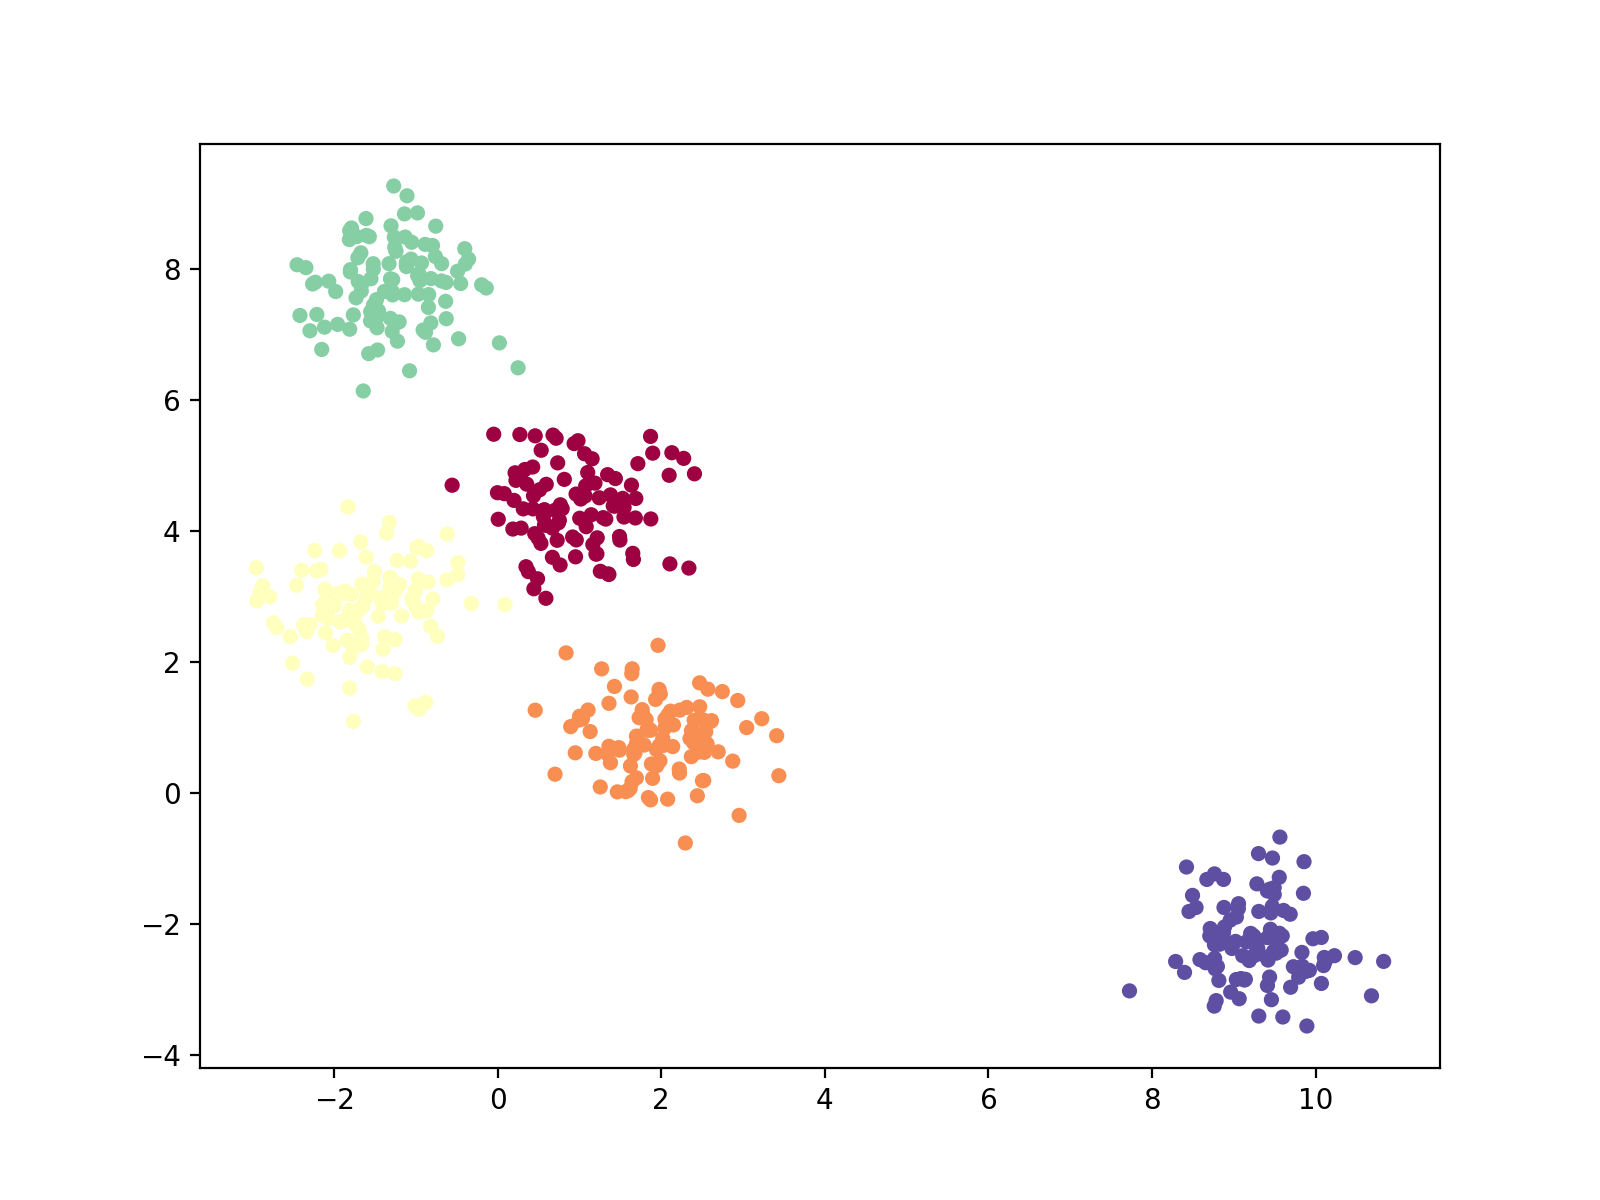

In [31]:
X, y = make_blobs(n_samples = 500, n_features = 2, centers = 5, 
                           cluster_std = 0.6, random_state = 0)
colors = np.array([plt.cm.Spectral(val)
          for val in np.linspace(0, 1, len(set(y)))])

points = X
plt.figure(figsize=(8,6))

plt.scatter(points[:,0], points[:,1], c= colors[y], s= 20)    

In [32]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

<IPython.core.display.Javascript object>


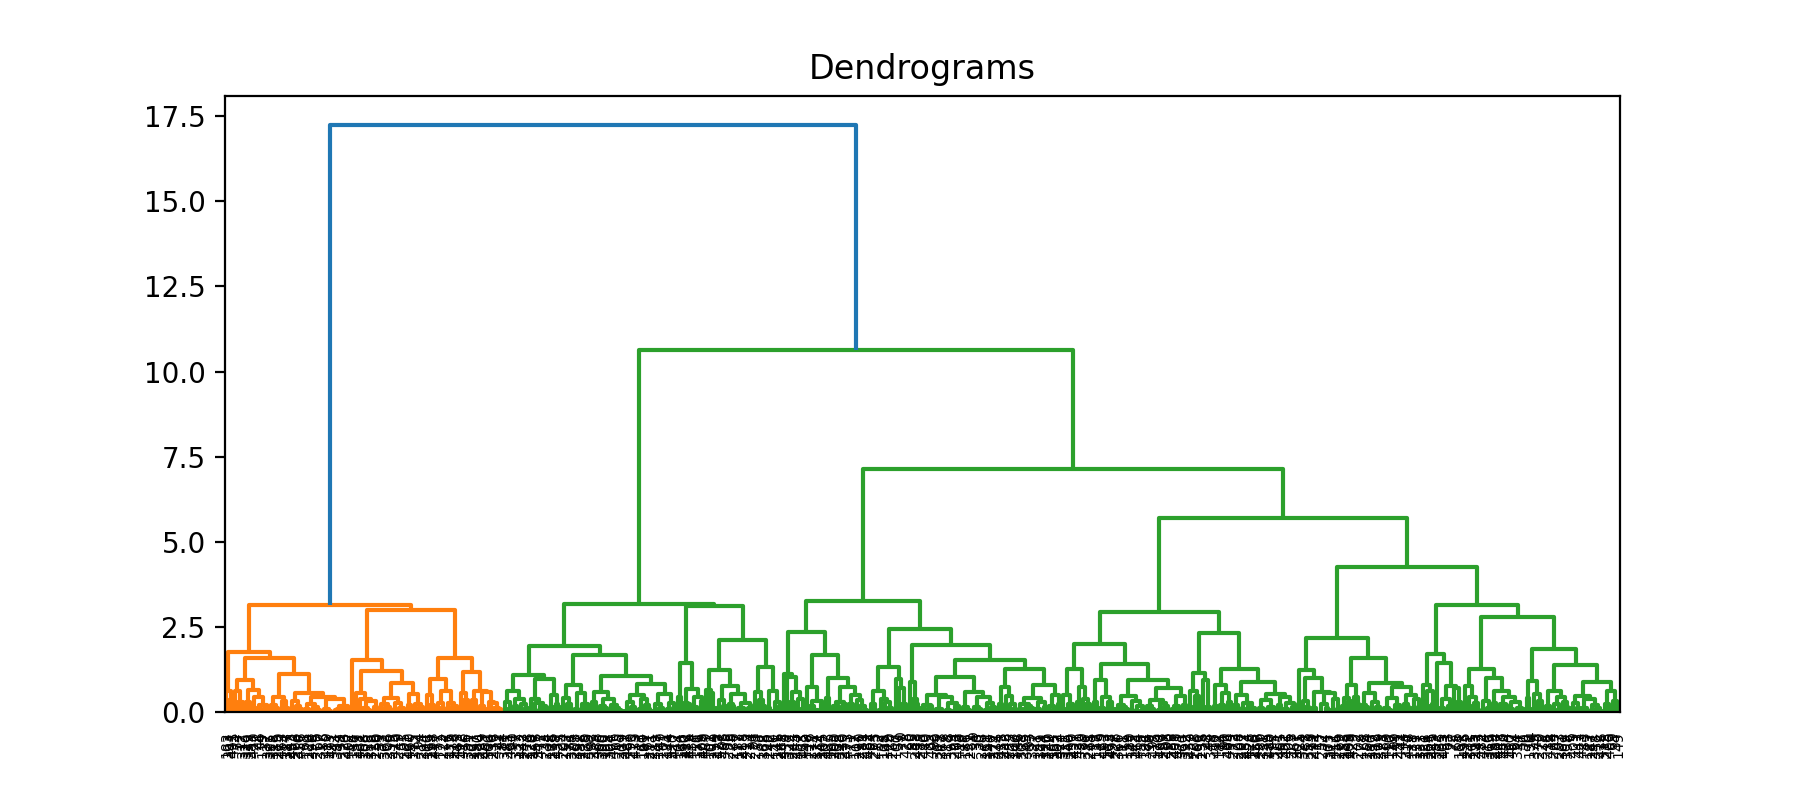

In [33]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(9, 4))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(points, method='complete'))

In [34]:
link_complete = AgglomerativeClustering(n_clusters=5, linkage='complete')
model = link_complete.fit(points)
print('Number of clusters for agglomerative clustering complete linkage:', link_complete.n_clusters)
predicted = link_complete.fit_predict(points)

Number of clusters for agglomerative clustering complete linkage: 5


<IPython.core.display.Javascript object>


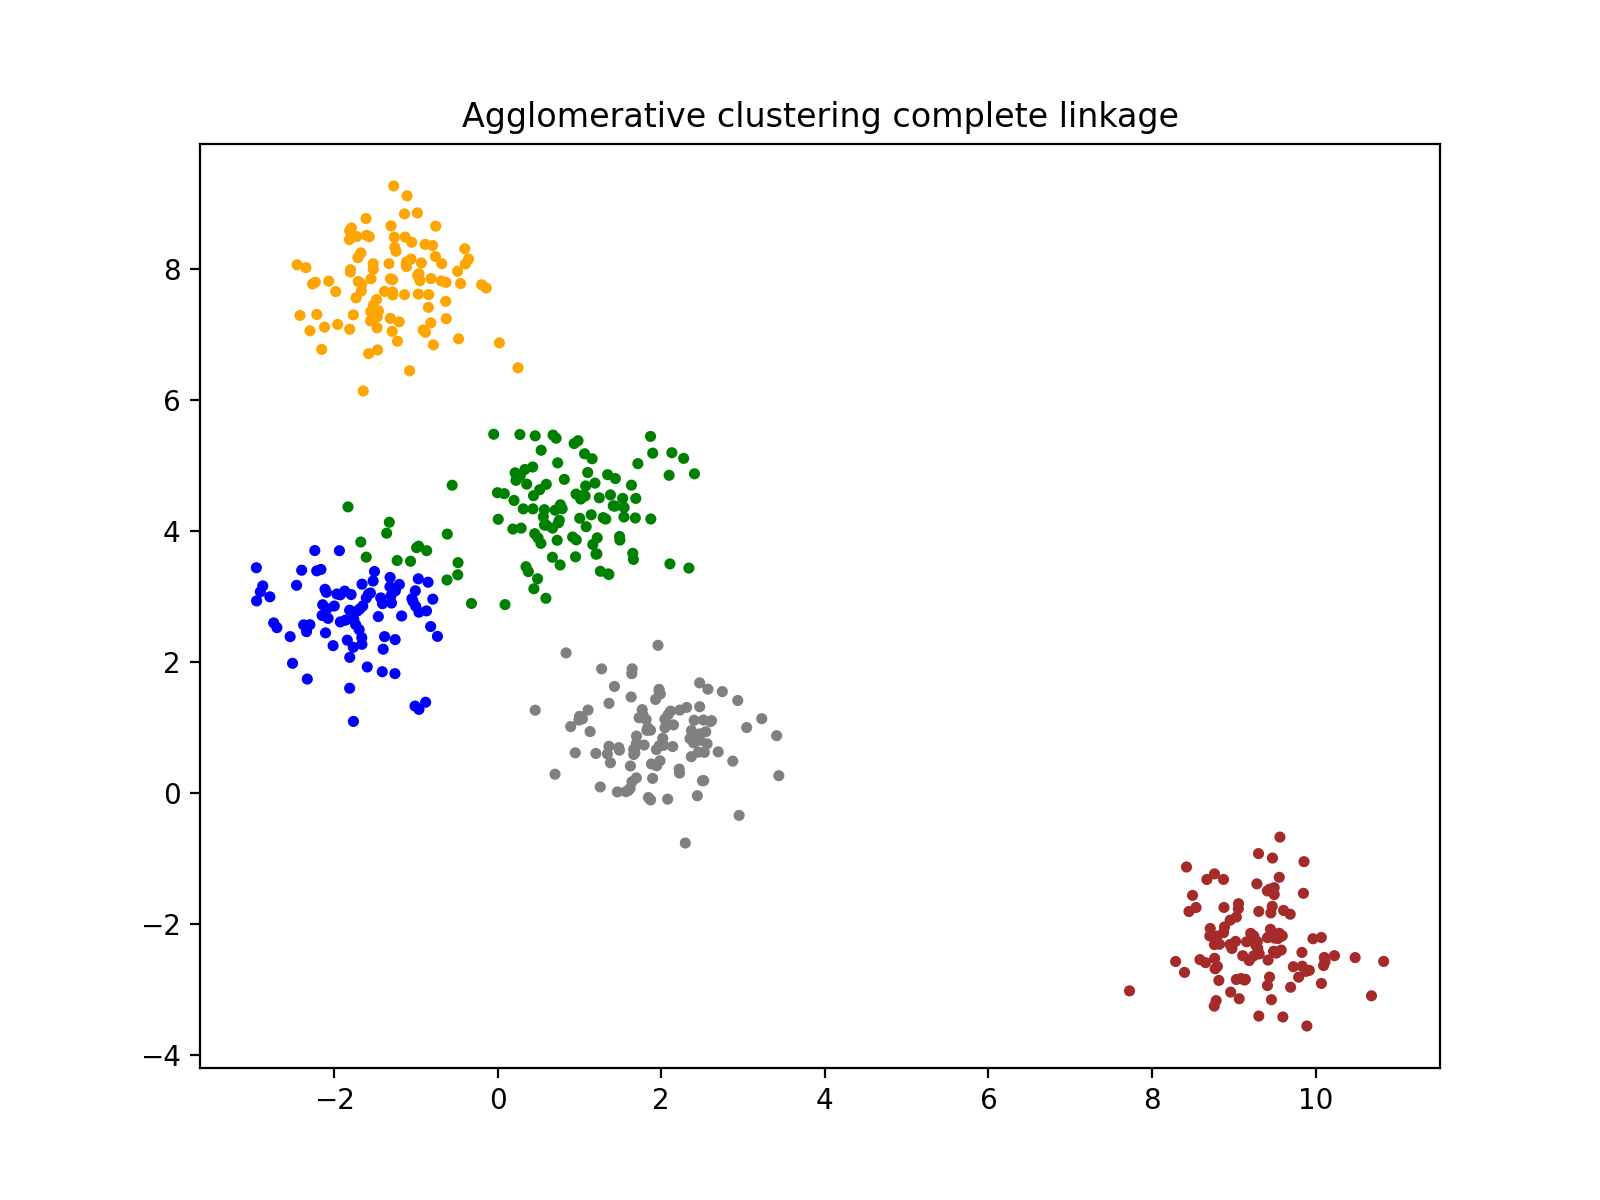

Text(0.5, 1.0, 'Agglomerative clustering complete linkage')

In [35]:
colors=  np.array(['green','grey', 'orange', 'brown', 'blue', 'yellow', 'pink'])
plt.figure(figsize=(8,6))
plt.scatter(points[:,0], points[:,1], c= colors[predicted], marker= '.')    
plt.title('Agglomerative clustering complete linkage')

<IPython.core.display.Javascript object>


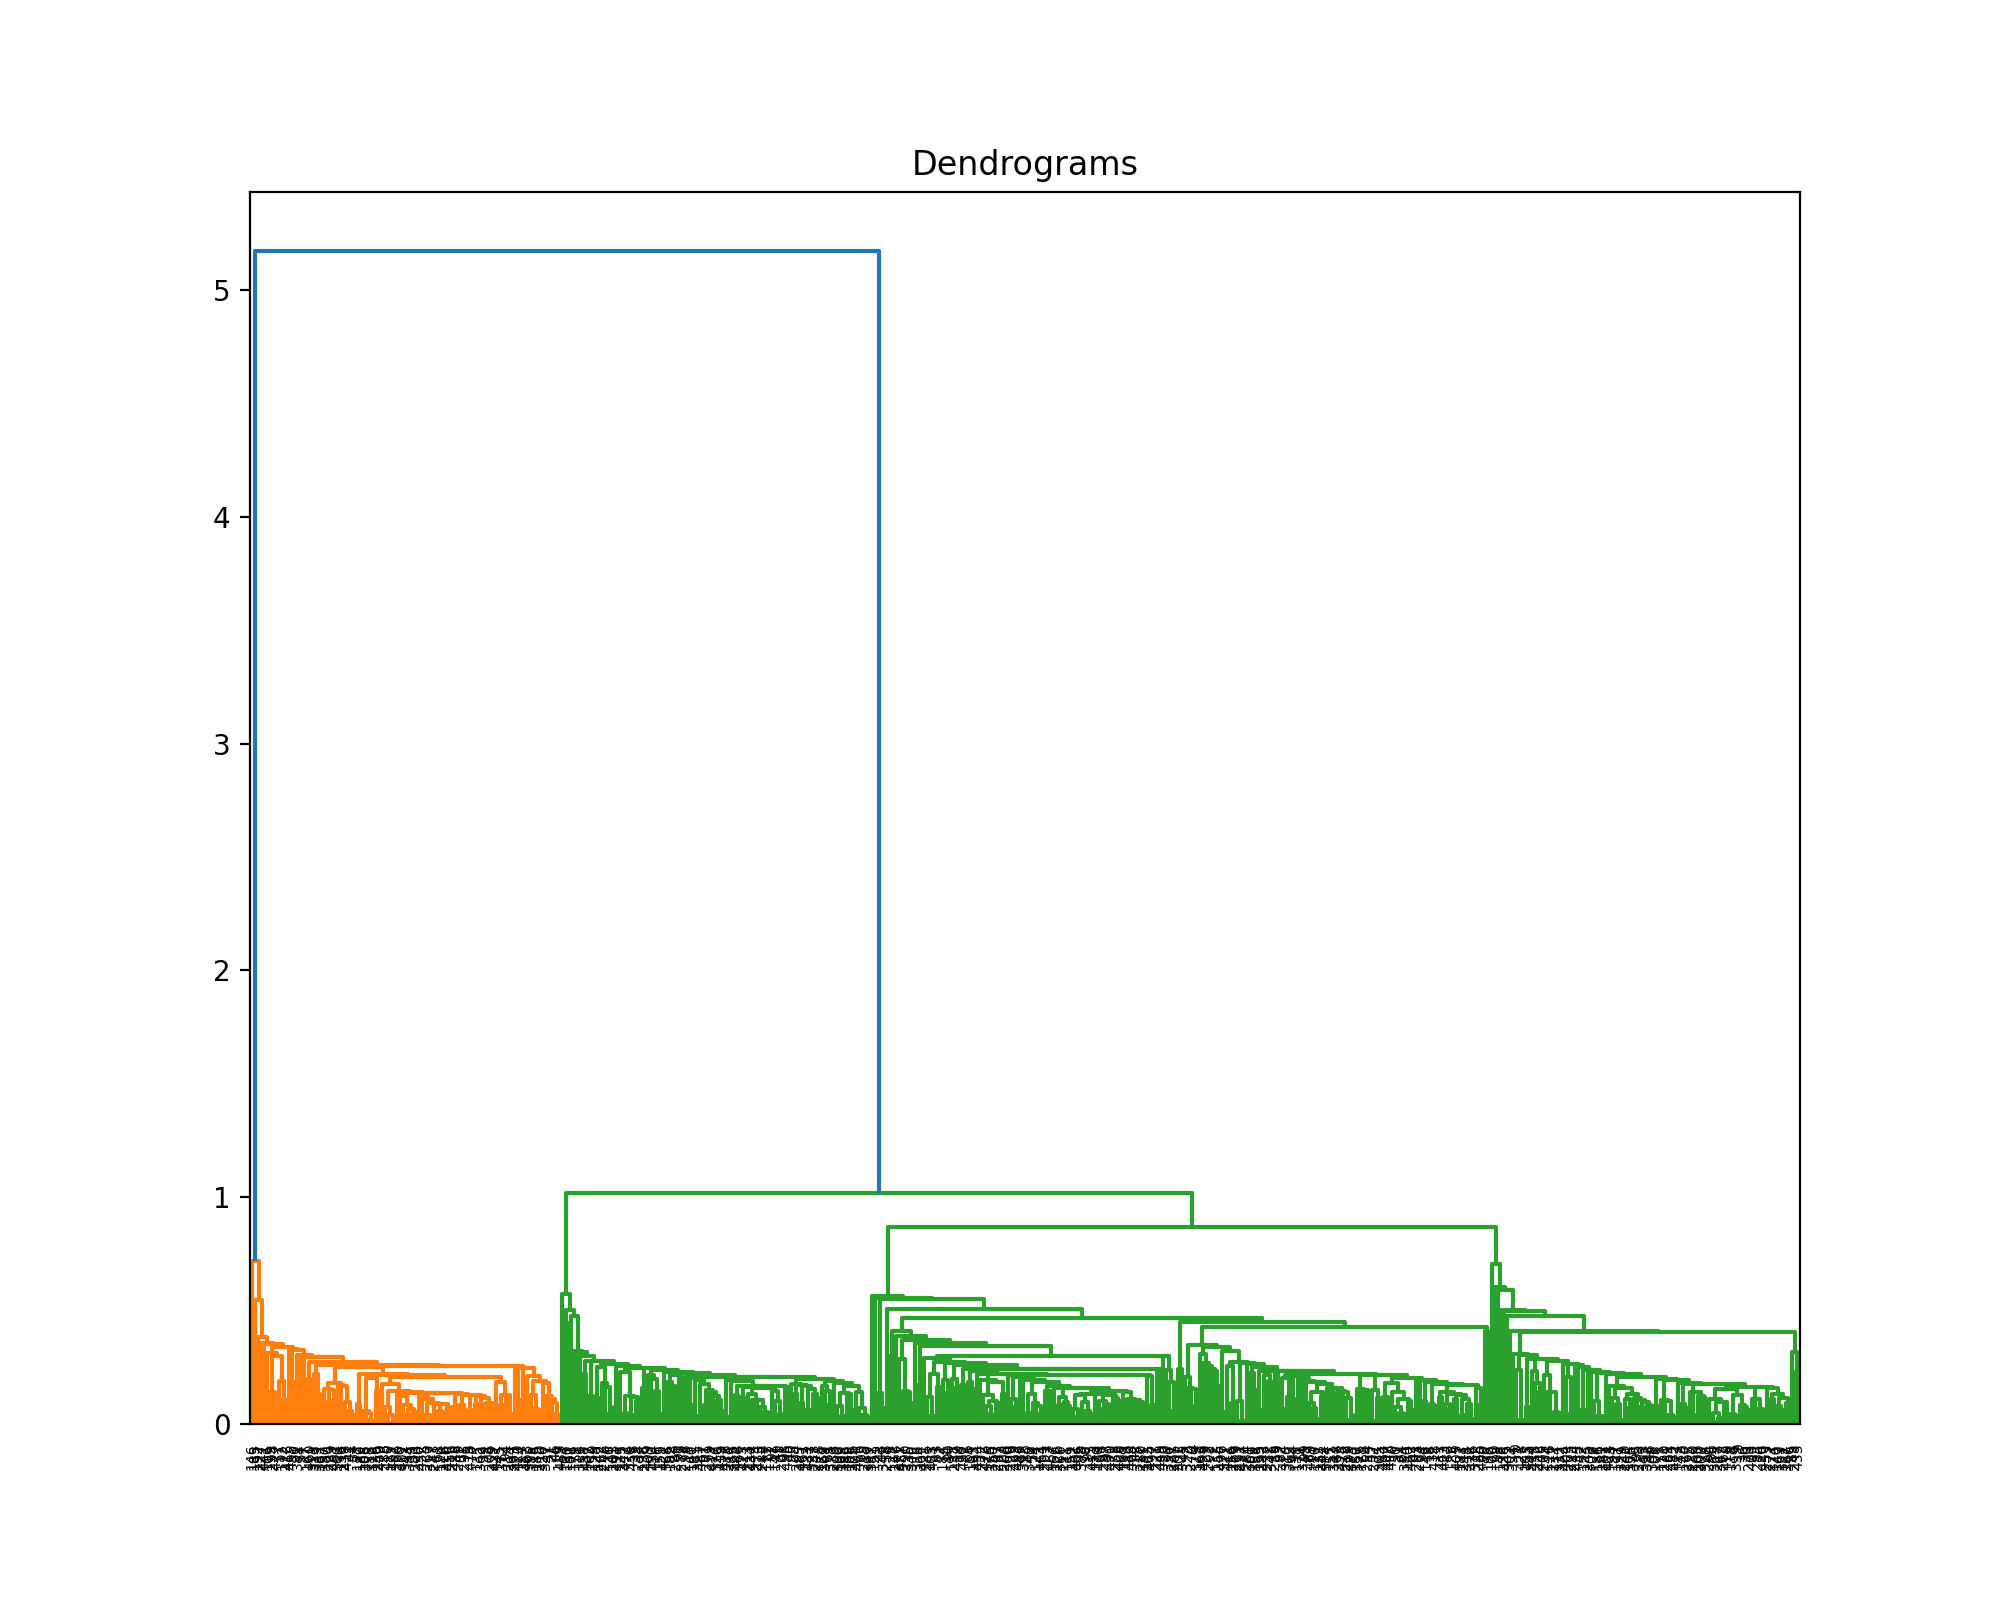

In [36]:
plt.figure(figsize=(10, 8))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(points, method='single'))

In [37]:
link_single = AgglomerativeClustering(n_clusters=4, linkage='single')
print('Number of clusters for agglomerative clustering single linkage:', link_single.n_clusters)
predicted = link_single.fit_predict(points)

Number of clusters for agglomerative clustering single linkage: 4


<IPython.core.display.Javascript object>


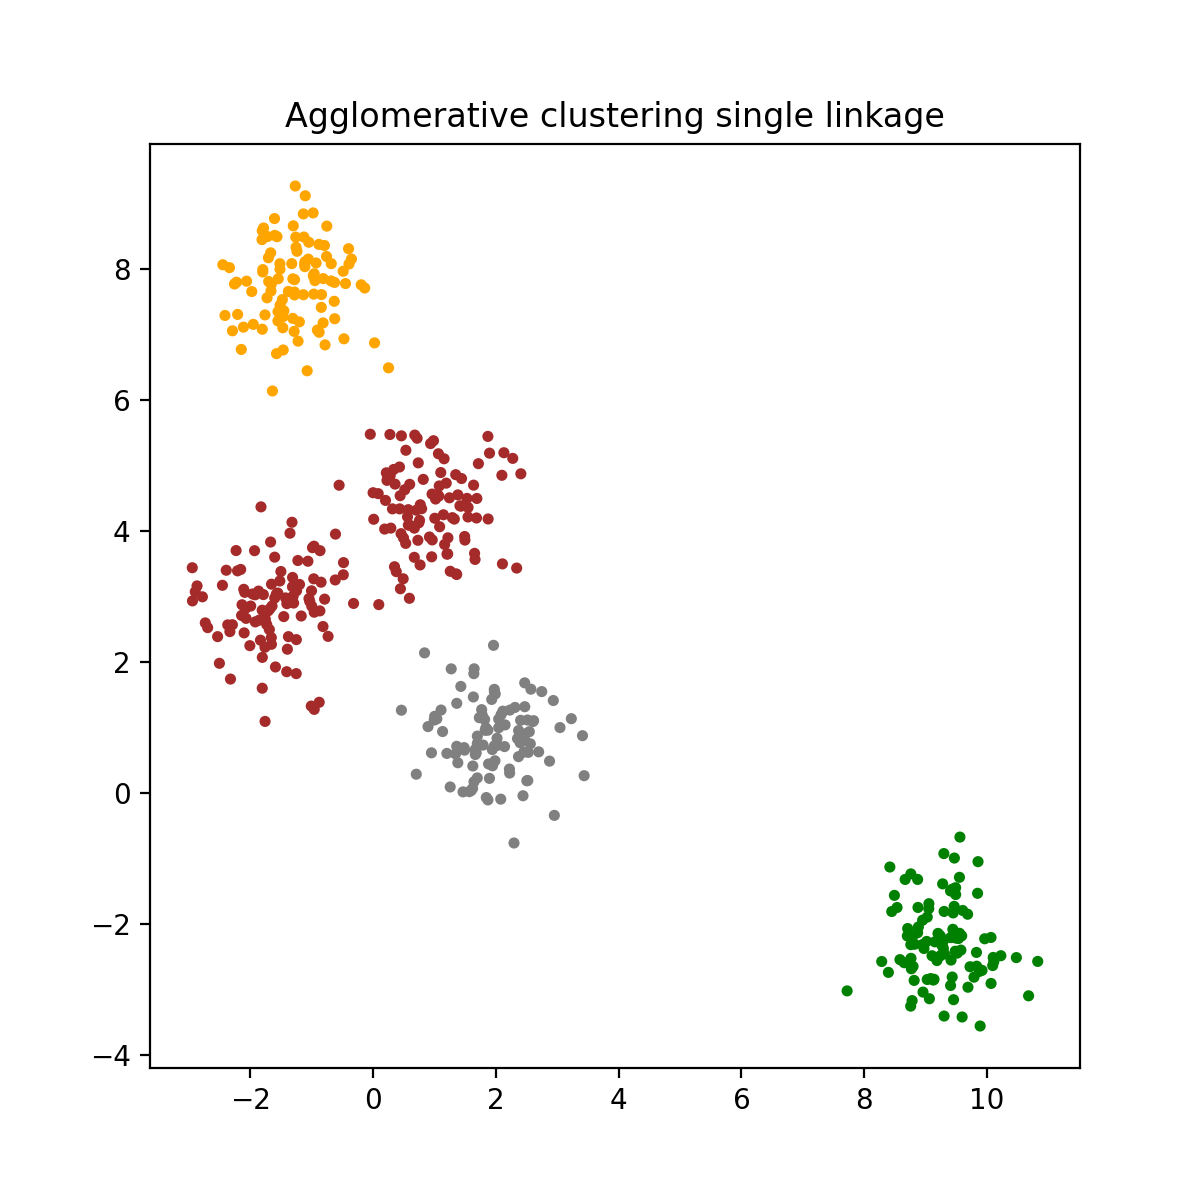

Text(0.5, 1.0, 'Agglomerative clustering single linkage')

In [38]:
plt.figure(figsize=(6,6))
plt.scatter(points[:,0], points[:,1], c= colors[predicted], marker= '.')    
plt.title ('Agglomerative clustering single linkage')

<IPython.core.display.Javascript object>


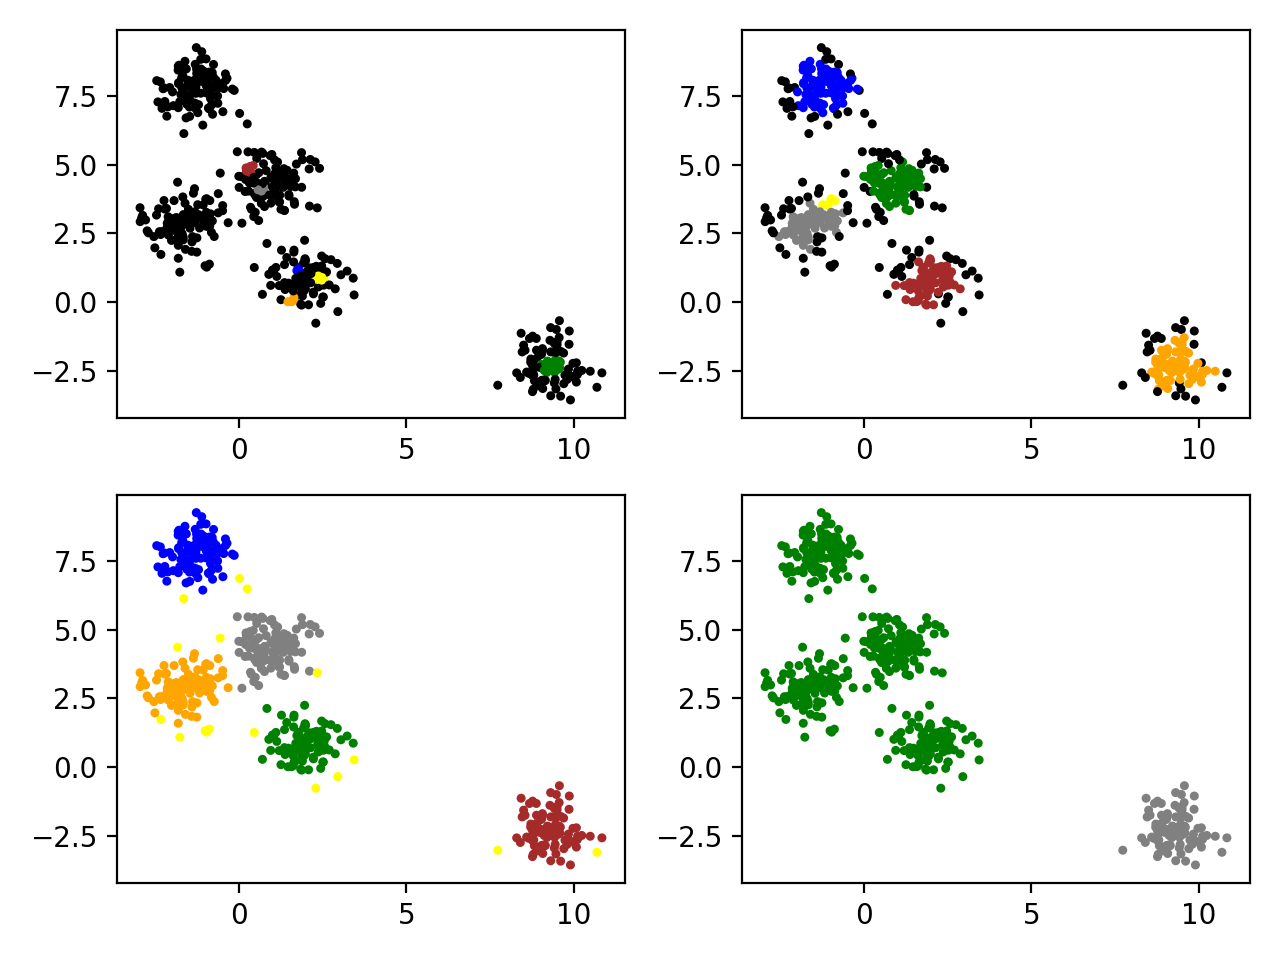

n_clusters_and_noice =21

n_clusters_and_noice =8

n_clusters_and_noice =5

n_clusters_and_noice =1



In [39]:
from sklearn.cluster import DBSCAN
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = (ax1, ax2, ax3, ax4)
for i, eps in enumerate([0.16, 0.27, 0.5, 1.8]):    
#     predicted  =  apply_db_scan(points, eps=eps)
    
    dbscan = DBSCAN(eps=eps, min_samples=5, ).fit(points) # default eps=0.5, min_samples=5
    # dbscan = DBSCAN(min_samples=6).fit(points)
    predicted = dbscan.labels_
    n_clusters_and_noice = len(np.unique(predicted))-1
    print ('n_clusters_and_noice ={}\n'.format(n_clusters_and_noice))

    predicted[np.where(predicted == -1)] = n_clusters_and_noice

    colors=  np.array(['green','grey', 'orange', 'brown', 'blue', 'yellow'])
    colors= np.r_[colors, np.array(['black']*100)]
    axes[i].scatter(points[:,0], points[:,1], c= colors[predicted], s= 5)    

plt.tight_layout()

<IPython.core.display.Javascript object>


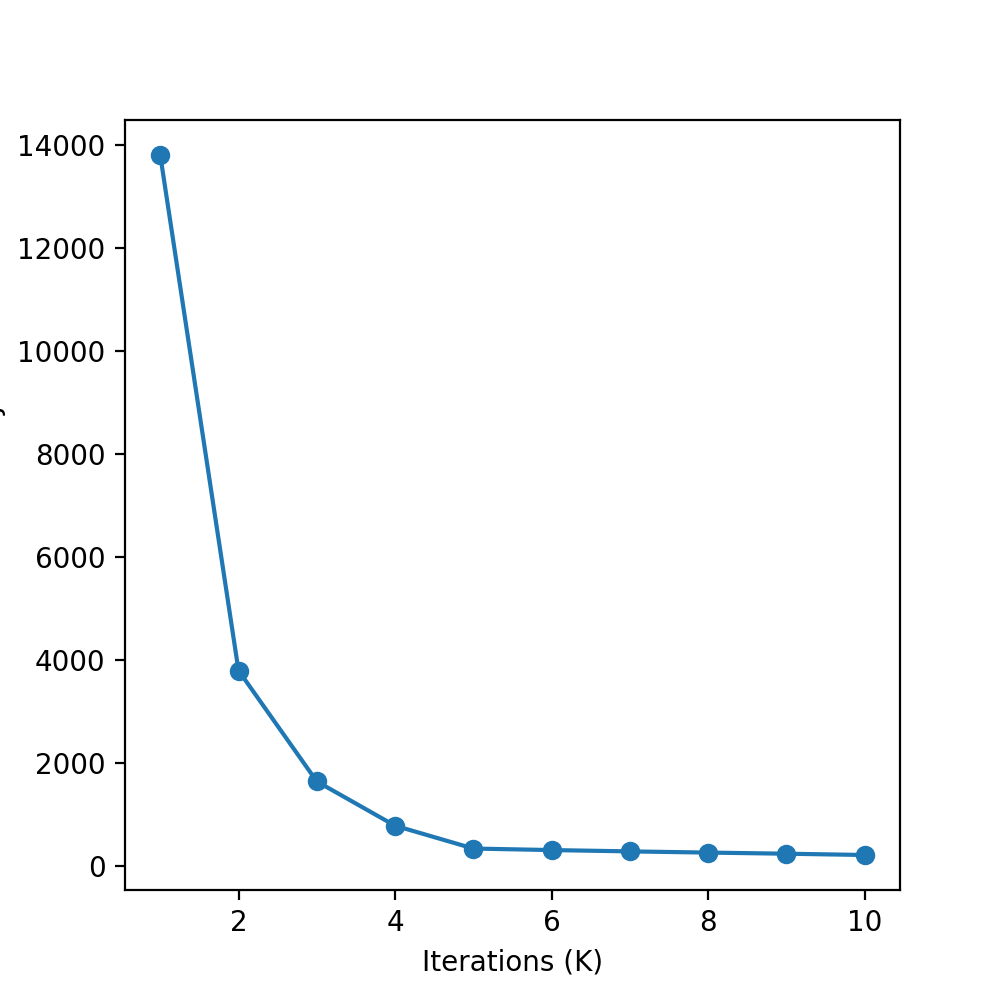

In [40]:
from sklearn.cluster import KMeans
J = []
K = range(1,11)
for num_clusters in K:
    clf = KMeans(n_clusters=num_clusters)
    clf.fit(points)
    J.append(clf.inertia_)
    predicted= clf.predict(points)
    centroids = clf.cluster_centers_
    x1, x2 = np.array(list((zip(*points))))
    colors = np.array(['green','orange','grey', 'brown', 'pink', 'blue', 'yellow', 'red', 'indigo', 'black'])

plt.figure(figsize= (5,5))
plt.plot(K,J,'o-')
plt.xlabel('Iterations (K)') 
plt.ylabel('Cost function J')
plt.show()

<IPython.core.display.Javascript object>


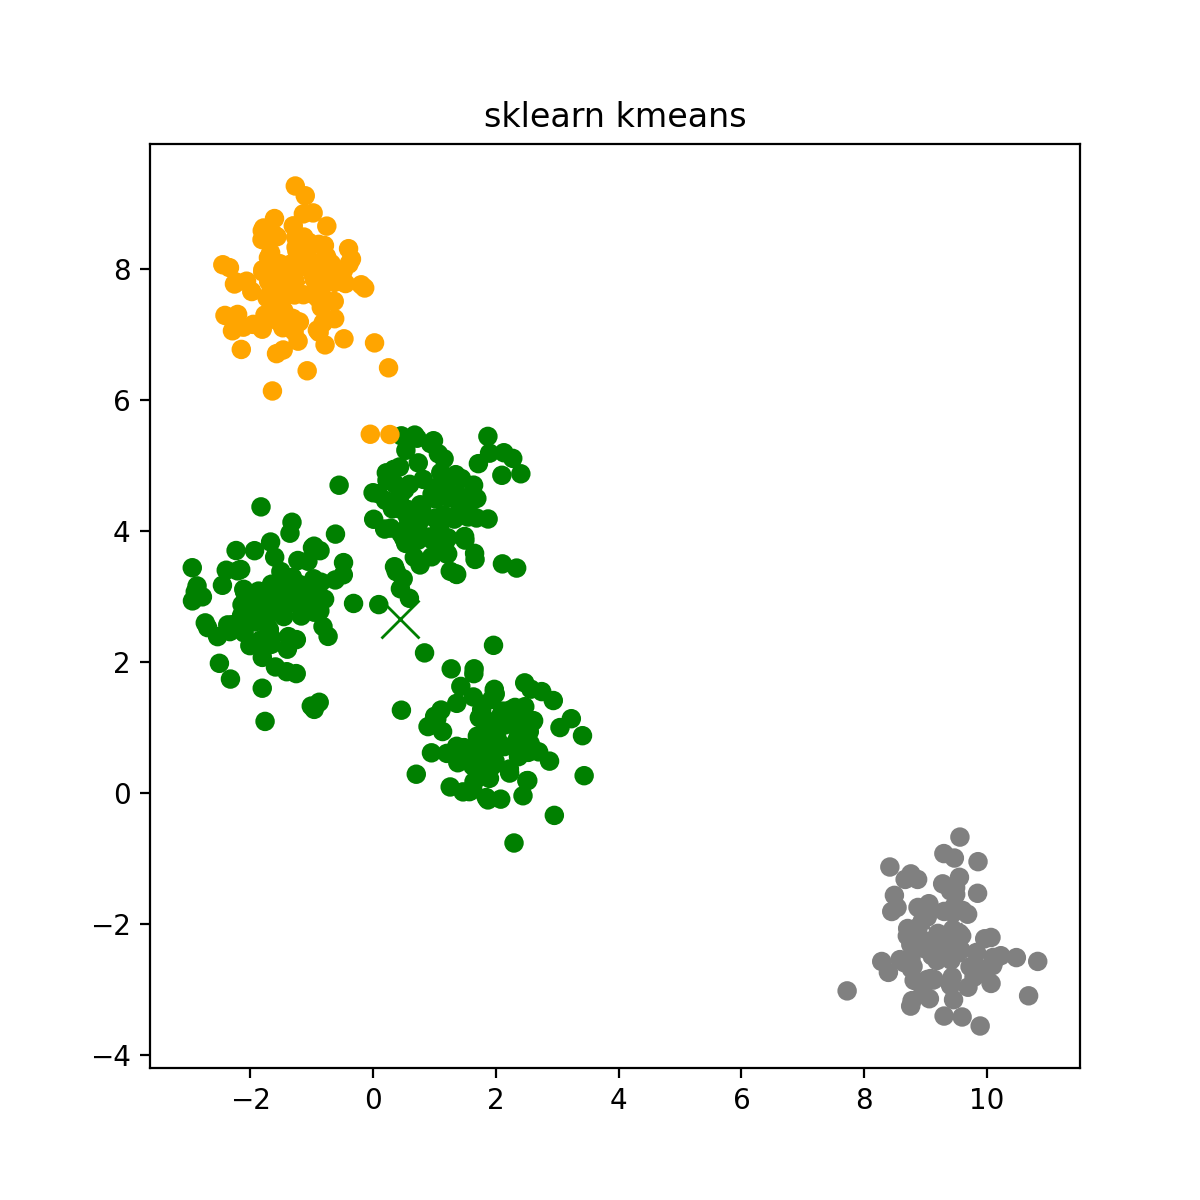

Text(0.5, 1.0, 'sklearn kmeans')

In [41]:
clf = KMeans(n_clusters=3, n_init = 10)
clf.fit(points)
predicted= clf.predict(points)
centroids = clf.cluster_centers_
x1, x2 = np.array(list((zip(*points))))
plt.figure(figsize=(6,6))

plt.scatter(x1,x2, c= colors[predicted])

for i, c in enumerate (clf.cluster_centers_):    
    plt.plot(c[0], c[1], marker = 'x', color= colors[i], markersize=14) 
    
plt.title('sklearn kmeans')

<font color = green >

## Learn more
</font>

[sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

[Hierarchical clustering (scipy.cluster.hierarchy)](https://docs.scipy.org/doc/scipy-0.9.0/reference/cluster.hierarchy.html)

[Demo of DBSCAN clustering algorithm](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html)
